In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import shutil

### Data import and organisation

In [ ]:
#following second approach to data handling - get all images to one folder first

In [2]:
path_metadata = 'data/HAM10000_metadata.csv'
skin_df = pd.read_csv(path_metadata)

In [3]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
data_dir = os.getcwd() + '/data/all_images'

In [5]:
# Read the csv file containing image names and corresponding labels
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [6]:
label=skin_df['dx'].unique().tolist()  #Extract labels into a list
print(label)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


In [7]:
# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "/data/HAM10000_organised/"

In [9]:
for i in label:
    os.mkdir(dest_dir + str(i) + "/")

In [12]:
# Copy images to new folders
label_images = []
for i in label:
    sample = skin_df[skin_df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[] 

In [15]:
#pre requisites to using this function is:
# 1.to have all images stored into one single folder named all_images
# 2. to name an empty folder for organised data - dest_dir = "HAM10000_organised"
def data_handler(path_metadata,data_dir,dest_dir):
    skin_df = pd.read_csv(path_metadata)
    label=skin_df['dx'].unique().tolist()
    for i in label:
        os.mkdir(dest_dir + str(i) + "/")
        
    label_images = []
    
    for i in label:
        sample = skin_df[skin_df['dx'] == i]['image_id']
        label_images.extend(sample)
        for id in label_images:
            shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
        label_images=[] 

### Classifier -1 
Using best model suggested by autokeras for classification

In [7]:
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [8]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [9]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [10]:
skin_df.index.has_duplicates

False

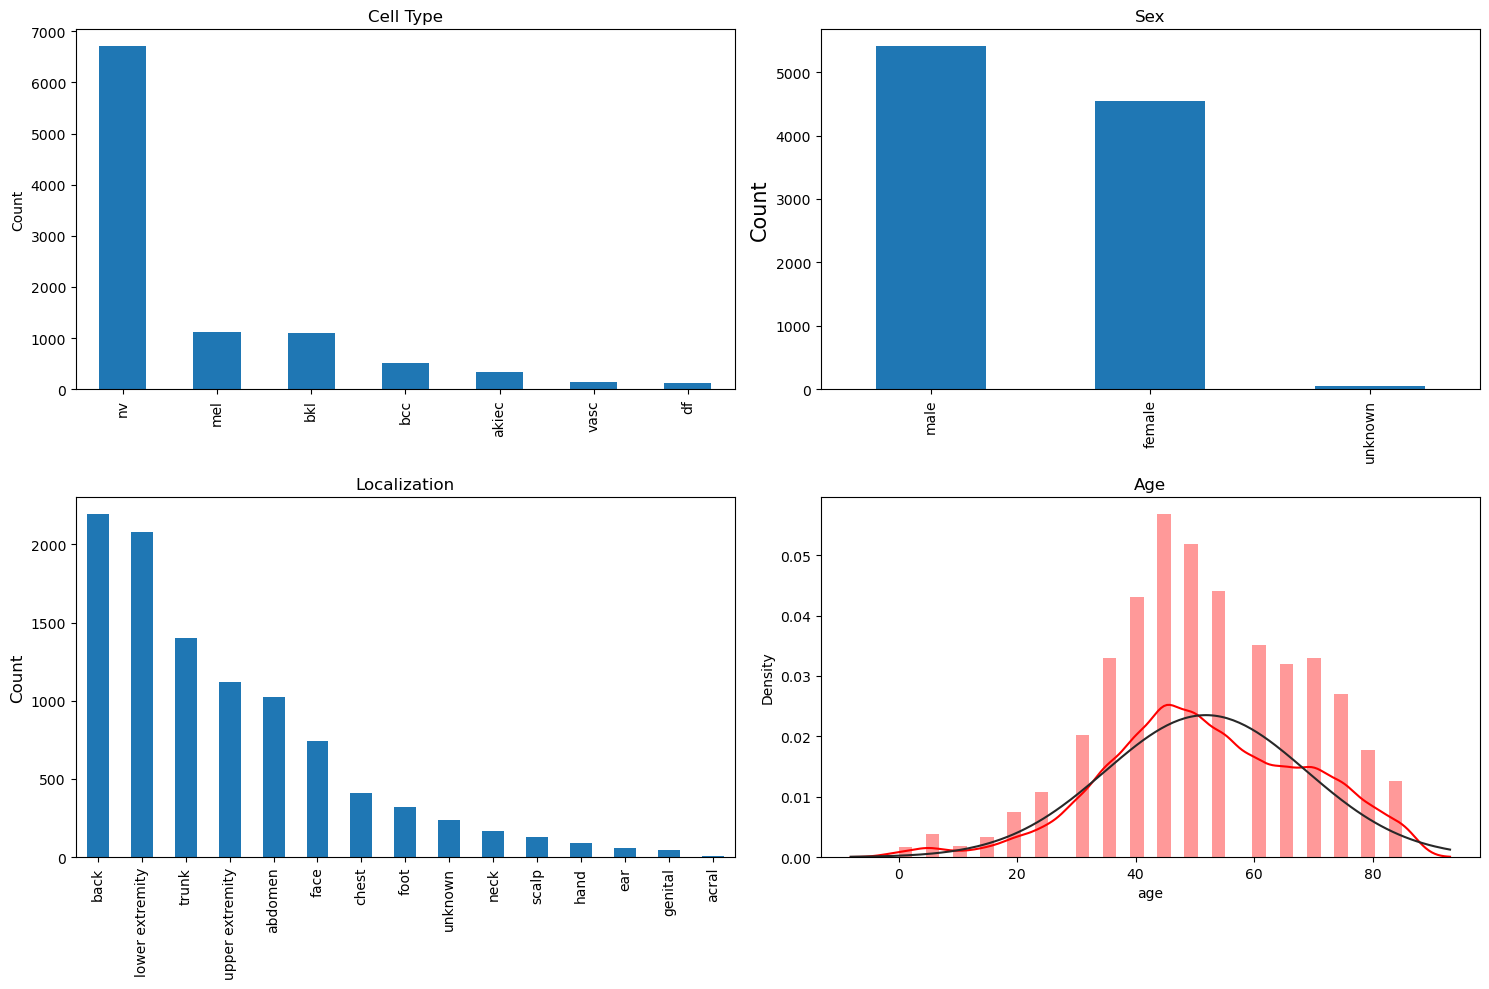

In [37]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [11]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [12]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [13]:
len(df_0)

327

In [15]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42,stratify=df_0['localization']) 
df_1_balanced = resample(df_1, replace=False, n_samples=n_samples, random_state=42,stratify=df_1['localization']) 
df_2_balanced = resample(df_2, replace=False, n_samples=n_samples, random_state=42,stratify=df_2['localization'])
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42,stratify=df_3['localization'])
df_4_balanced = resample(df_4, replace=False, n_samples=n_samples, random_state=42,stratify=df_4['localization'])
df_5_balanced = resample(df_5, replace=False, n_samples=n_samples, random_state=42,stratify=df_5['localization'])
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42,stratify=df_6['localization'])

In [16]:

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [17]:
skin_df_balanced.index.has_duplicates

True

In [18]:
skin_df_balanced.reset_index(inplace=True,drop=True)

In [19]:
skin_df_balanced.index.has_duplicates

False

In [20]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0003262,ISIC_0026212,akiec,histo,45.0,male,face,0
1,HAM_0001023,ISIC_0026468,akiec,histo,50.0,male,hand,0
2,HAM_0005448,ISIC_0024707,akiec,histo,60.0,male,face,0
3,HAM_0006220,ISIC_0028517,akiec,histo,60.0,male,upper extremity,0
4,HAM_0005648,ISIC_0027580,akiec,histo,75.0,male,upper extremity,0


In [21]:
skin_df_balanced.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
3495,HAM_0004791,ISIC_0033591,vasc,histo,80.0,female,lower extremity,6
3496,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,6
3497,HAM_0004820,ISIC_0030722,vasc,consensus,45.0,female,abdomen,6
3498,HAM_0006946,ISIC_0033349,vasc,histo,55.0,female,back,6
3499,HAM_0002610,ISIC_0030606,vasc,consensus,0.0,female,abdomen,6


In [22]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


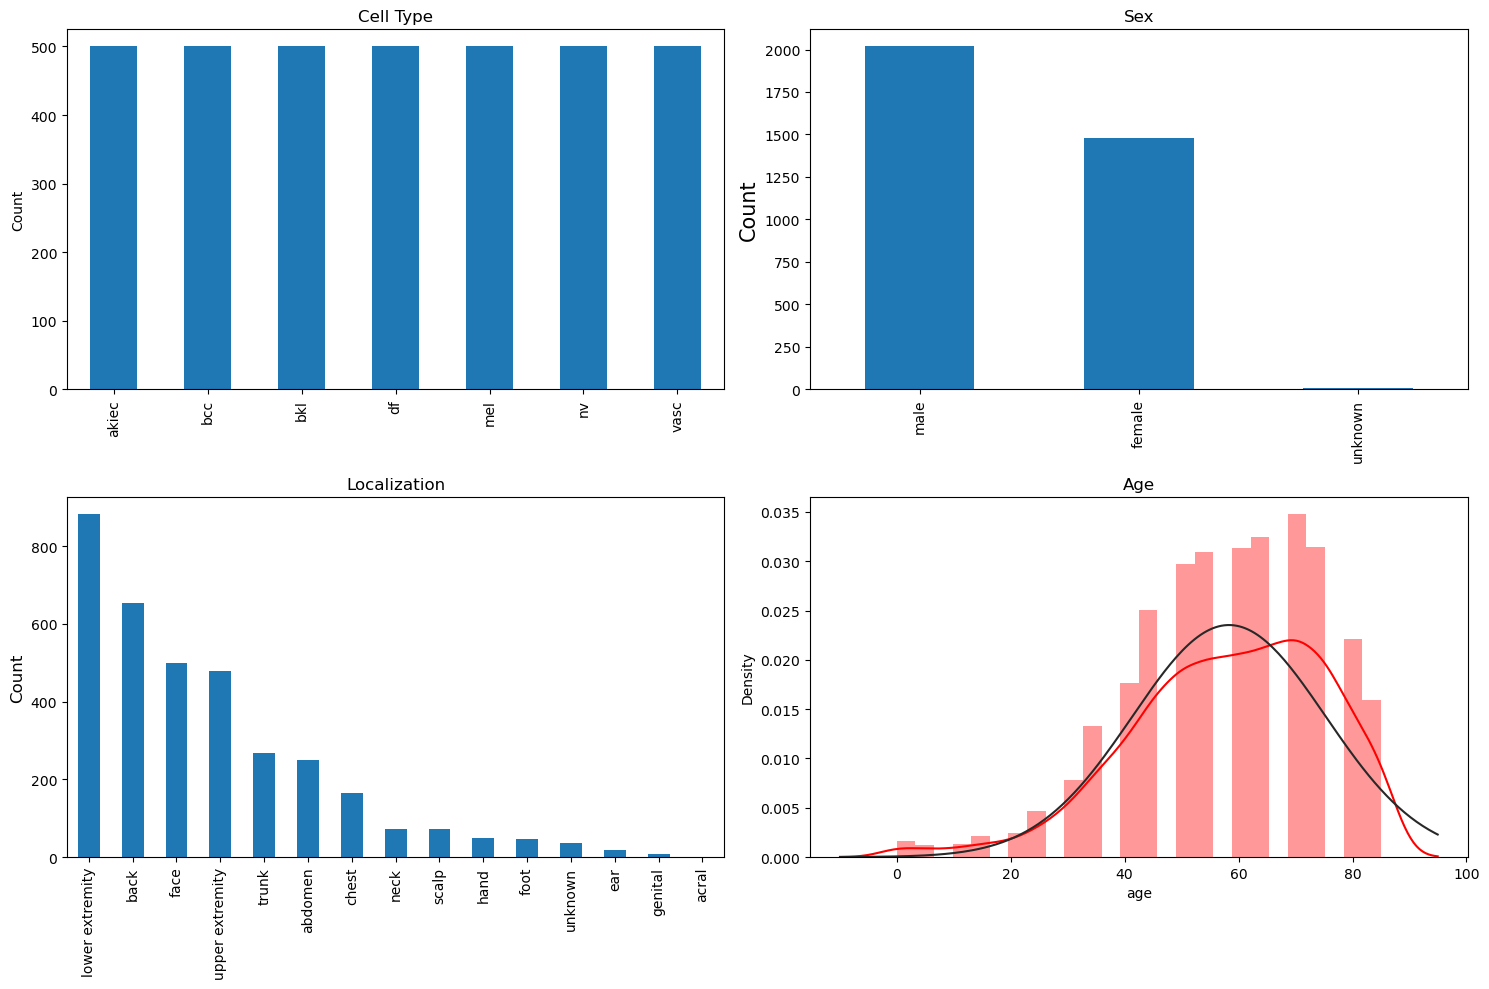

In [123]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df_balanced['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df_balanced['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df_balanced['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df_balanced[pd.notnull(skin_df_balanced['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [23]:
SIZE=32
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/all_images/', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [24]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
0,HAM_0003262,ISIC_0026212,akiec,histo,45.0,male,face,0,data/all_images/ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0001023,ISIC_0026468,akiec,histo,50.0,male,hand,0,data/all_images/ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0005448,ISIC_0024707,akiec,histo,60.0,male,face,0,data/all_images/ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0006220,ISIC_0028517,akiec,histo,60.0,male,upper extremity,0,data/all_images/ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0005648,ISIC_0027580,akiec,histo,75.0,male,upper extremity,0,data/all_images/ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


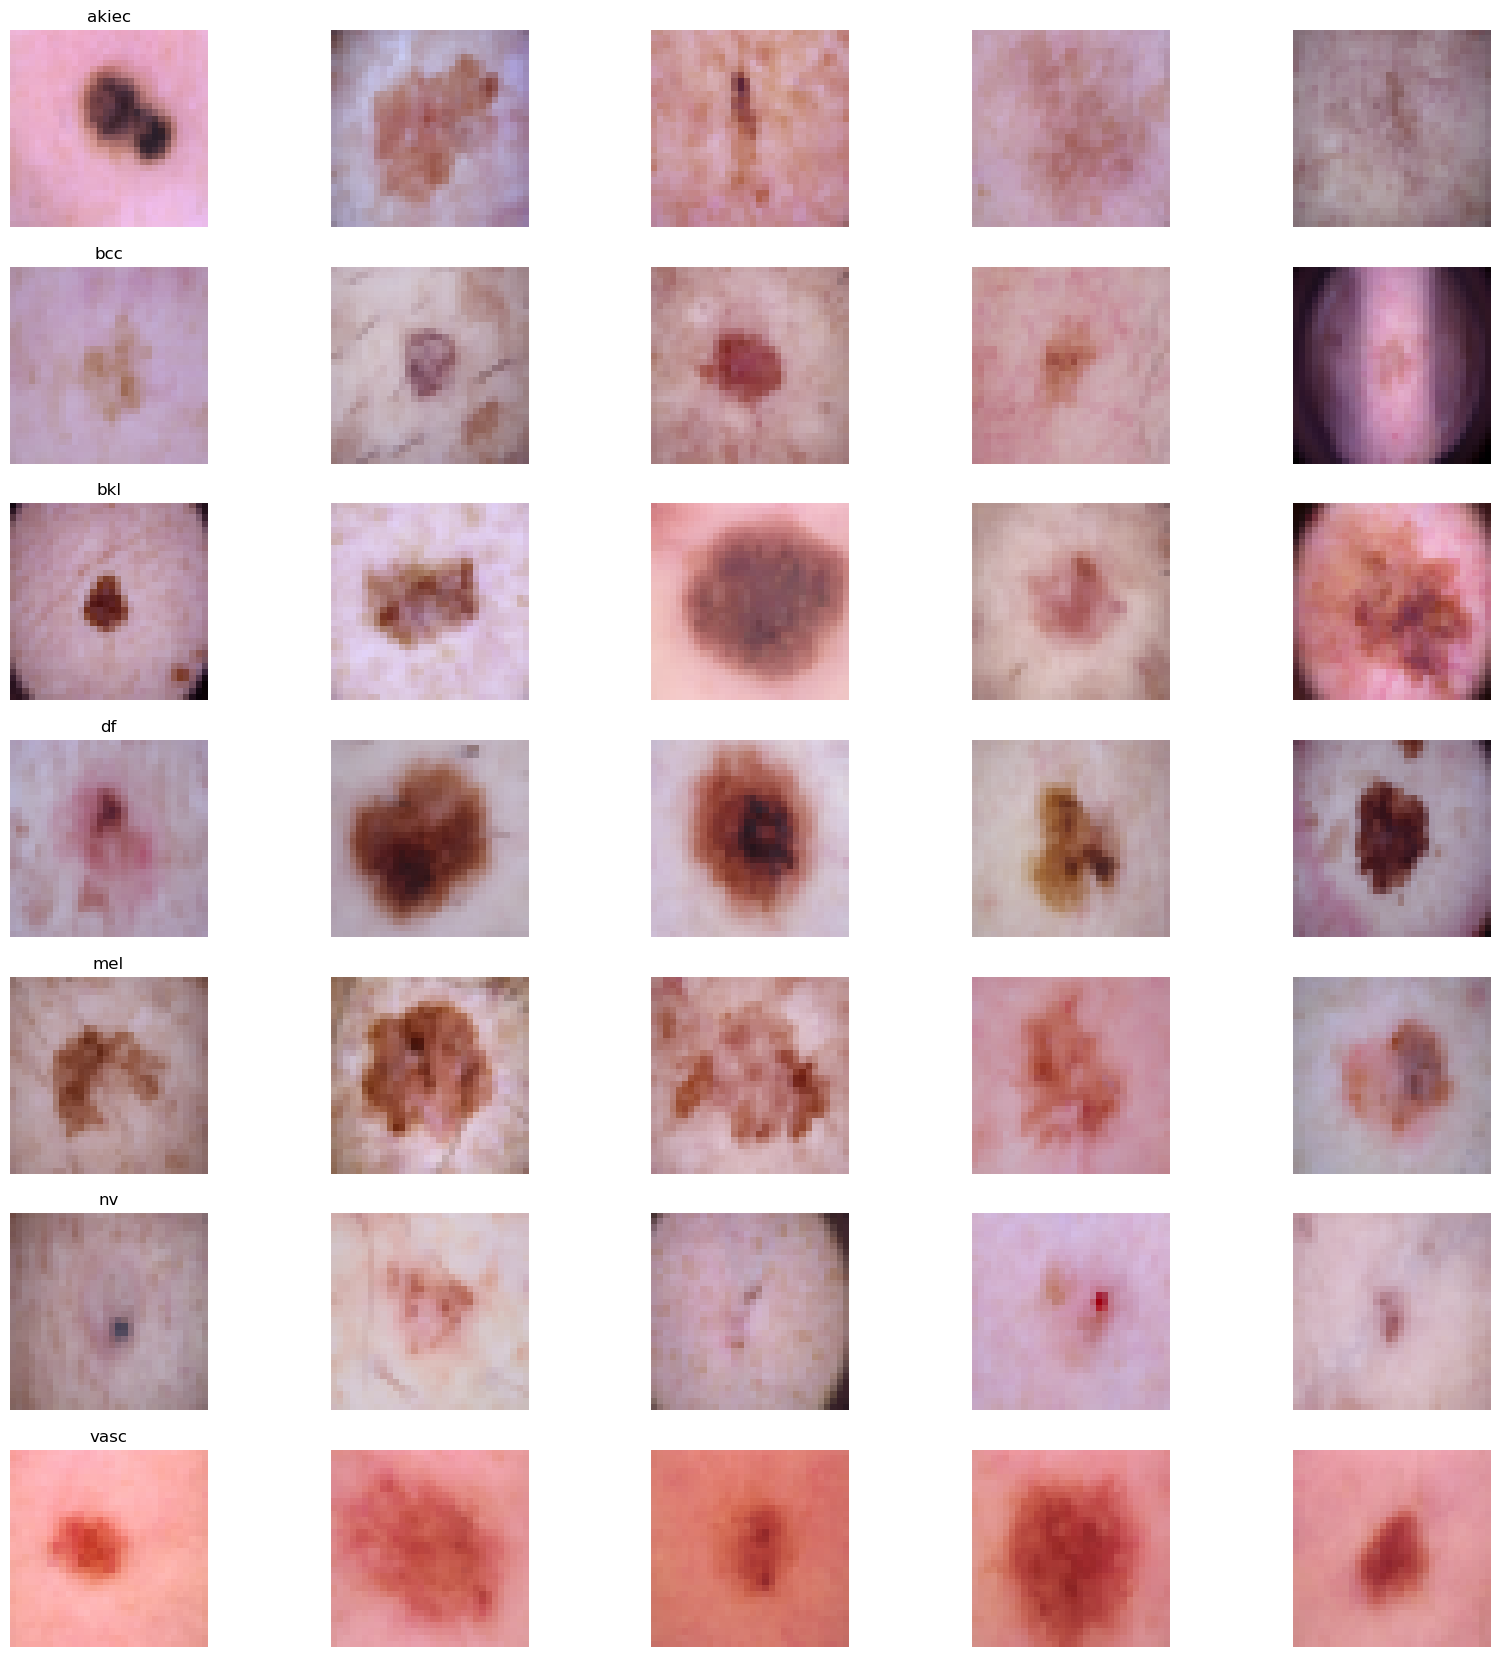

In [25]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [26]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods. rescale using tf layer later
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 

In [27]:
print(X.shape)
print(Y.shape)

(3500, 32, 32, 3)
(3500,)


In [28]:
X[0].shape

(32, 32, 3)

In [29]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [30]:
print(x_train.shape)
print(x_test.shape)

(2625, 32, 32, 3)
(875, 32, 32, 3)


In [50]:
#Define the model.

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

2022-12-01 14:17:19.719815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 14:17:19.720838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 batch_normalization_1 (Ba

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [53]:
#training in memory
from time import time
start_time =time()
batch_size = 32
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)
end_time = time()

Epoch 1/50


2022-12-01 14:22:37.957782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 14:22:38.187617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 14:22:46.768341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 - 9s - loss: 2.0170 - acc: 0.3531 - val_loss: 2.1261 - val_acc: 0.1886 - 9s/epoch - 112ms/step
Epoch 2/50
83/83 - 2s - loss: 1.5056 - acc: 0.4648 - val_loss: 2.2315 - val_acc: 0.1749 - 2s/epoch - 26ms/step
Epoch 3/50
83/83 - 2s - loss: 1.4197 - acc: 0.4800 - val_loss: 2.2638 - val_acc: 0.1817 - 2s/epoch - 25ms/step
Epoch 4/50
83/83 - 2s - loss: 1.2788 - acc: 0.5314 - val_loss: 2.2328 - val_acc: 0.1657 - 2s/epoch - 25ms/step
Epoch 5/50
83/83 - 2s - loss: 1.1550 - acc: 0.5669 - val_loss: 2.0651 - val_acc: 0.1840 - 2s/epoch - 24ms/step
Epoch 6/50
83/83 - 2s - loss: 1.1213 - acc: 0.5703 - val_loss: 1.8786 - val_acc: 0.3143 - 2s/epoch - 25ms/step
Epoch 7/50
83/83 - 2s - loss: 1.1323 - acc: 0.5863 - val_loss: 1.4418 - val_acc: 0.4366 - 2s/epoch - 25ms/step
Epoch 8/50
83/83 - 2s - loss: 1.1498 - acc: 0.5768 - val_loss: 1.4567 - val_acc: 0.4526 - 2s/epoch - 25ms/step
Epoch 9/50
83/83 - 2s - loss: 1.1117 - acc: 0.5756 - val_loss: 1.3704 - val_acc: 0.4846 - 2s/epoch - 25ms/step
Epoch 10/50

In [54]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 0s 14ms/step - loss: 0.7238 - acc: 0.7669
Test accuracy: 0.7668571472167969


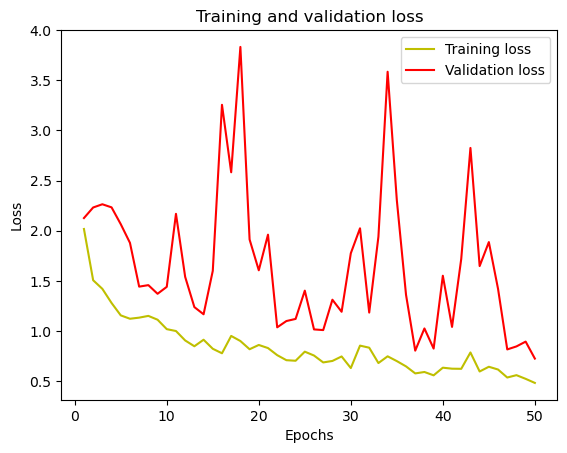

In [55]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

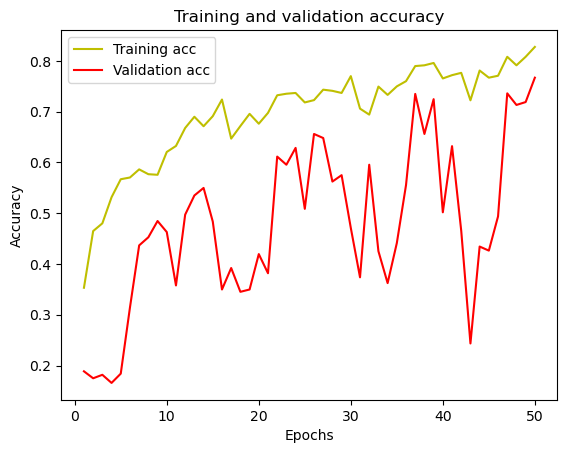

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
training_time_50epochs = end_time -start_time
print(training_time_50epochs)

110.5493803024292


In [58]:
#training in memory
from time import time
start_time =time()
batch_size = 16
epochs = 100

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)
end_time = time()

Epoch 1/100
165/165 - 4s - loss: 0.5726 - acc: 0.8015 - val_loss: 2.0535 - val_acc: 0.5291 - 4s/epoch - 25ms/step
Epoch 2/100
165/165 - 3s - loss: 0.6171 - acc: 0.7790 - val_loss: 1.1126 - val_acc: 0.6091 - 3s/epoch - 18ms/step
Epoch 3/100
165/165 - 3s - loss: 0.5411 - acc: 0.8008 - val_loss: 0.7772 - val_acc: 0.7337 - 3s/epoch - 19ms/step
Epoch 4/100
165/165 - 3s - loss: 0.5333 - acc: 0.8042 - val_loss: 0.7795 - val_acc: 0.7417 - 3s/epoch - 19ms/step
Epoch 5/100
165/165 - 3s - loss: 0.4909 - acc: 0.8168 - val_loss: 0.9541 - val_acc: 0.6811 - 3s/epoch - 20ms/step
Epoch 6/100
165/165 - 3s - loss: 0.4478 - acc: 0.8370 - val_loss: 1.0318 - val_acc: 0.6731 - 3s/epoch - 20ms/step
Epoch 7/100
165/165 - 3s - loss: 0.4553 - acc: 0.8381 - val_loss: 1.3088 - val_acc: 0.5840 - 3s/epoch - 19ms/step
Epoch 8/100
165/165 - 3s - loss: 0.4727 - acc: 0.8324 - val_loss: 1.3097 - val_acc: 0.6000 - 3s/epoch - 18ms/step
Epoch 9/100
165/165 - 3s - loss: 0.5111 - acc: 0.8187 - val_loss: 1.1765 - val_acc: 0.62

Epoch 73/100
165/165 - 3s - loss: 0.1274 - acc: 0.9554 - val_loss: 1.0652 - val_acc: 0.7680 - 3s/epoch - 18ms/step
Epoch 74/100
165/165 - 3s - loss: 0.1439 - acc: 0.9463 - val_loss: 1.0226 - val_acc: 0.7851 - 3s/epoch - 18ms/step
Epoch 75/100
165/165 - 3s - loss: 0.2207 - acc: 0.9219 - val_loss: 0.9712 - val_acc: 0.7760 - 3s/epoch - 18ms/step
Epoch 76/100
165/165 - 3s - loss: 0.1354 - acc: 0.9535 - val_loss: 1.0235 - val_acc: 0.7726 - 3s/epoch - 17ms/step
Epoch 77/100
165/165 - 3s - loss: 0.1158 - acc: 0.9589 - val_loss: 0.9595 - val_acc: 0.7806 - 3s/epoch - 19ms/step
Epoch 78/100
165/165 - 3s - loss: 0.1318 - acc: 0.9592 - val_loss: 0.9984 - val_acc: 0.7966 - 3s/epoch - 18ms/step
Epoch 79/100
165/165 - 3s - loss: 0.0975 - acc: 0.9676 - val_loss: 1.0616 - val_acc: 0.7794 - 3s/epoch - 18ms/step
Epoch 80/100
165/165 - 3s - loss: 0.1202 - acc: 0.9592 - val_loss: 0.9216 - val_acc: 0.7874 - 3s/epoch - 18ms/step
Epoch 81/100
165/165 - 3s - loss: 0.1541 - acc: 0.9451 - val_loss: 1.1432 - val_

In [59]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 0s 14ms/step - loss: 1.1552 - acc: 0.7600
Test accuracy: 0.7599999904632568


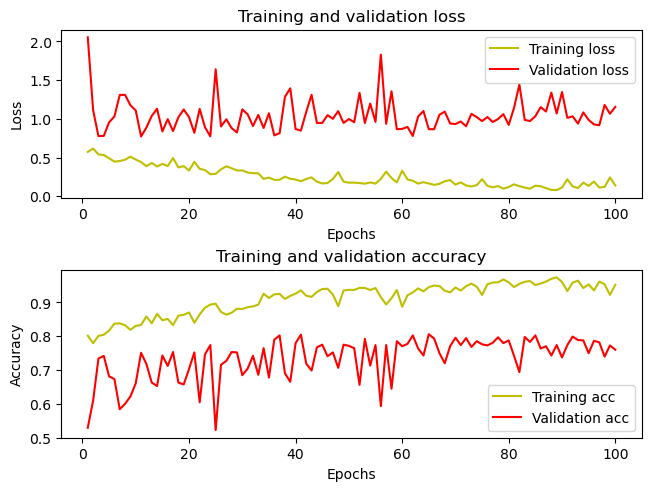

In [63]:
fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.show()


In [226]:
#function to train model and generate plots for the same train test split data

def train_model(model,batch_size,epochs):
    history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)
    
    print("training completed..")
    
    score = model.evaluate(x_test, y_test)
    print('Test accuracy:', score[1])
    
    #generate plots
    fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, 'y', label='Training loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    ax2.plot(epochs, acc, 'y', label='Training acc')
    ax2.plot(epochs, val_acc, 'r', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.show()

Epoch 1/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1069 - acc: 0.9661 - val_loss: 0.9001 - val_acc: 0.8046
Epoch 2/50
165/165 [==============================] - 3s 20ms/step - loss: 0.0941 - acc: 0.9672 - val_loss: 0.9345 - val_acc: 0.7943
Epoch 3/50
165/165 [==============================] - 3s 21ms/step - loss: 0.0915 - acc: 0.9707 - val_loss: 1.0111 - val_acc: 0.7806
Epoch 4/50
165/165 [==============================] - 3s 19ms/step - loss: 0.1131 - acc: 0.9577 - val_loss: 0.9117 - val_acc: 0.8103
Epoch 5/50
165/165 [==============================] - 4s 22ms/step - loss: 0.0784 - acc: 0.9703 - val_loss: 0.9699 - val_acc: 0.8034
Epoch 6/50
165/165 [==============================] - 3s 21ms/step - loss: 0.0843 - acc: 0.9665 - val_loss: 1.0766 - val_acc: 0.7806
Epoch 7/50
165/165 [==============================] - 3s 21ms/step - loss: 0.0750 - acc: 0.9779 - val_loss: 0.9917 - val_acc: 0.7966
Epoch 8/50
165/165 [==============================] - 4s 21ms/step - 

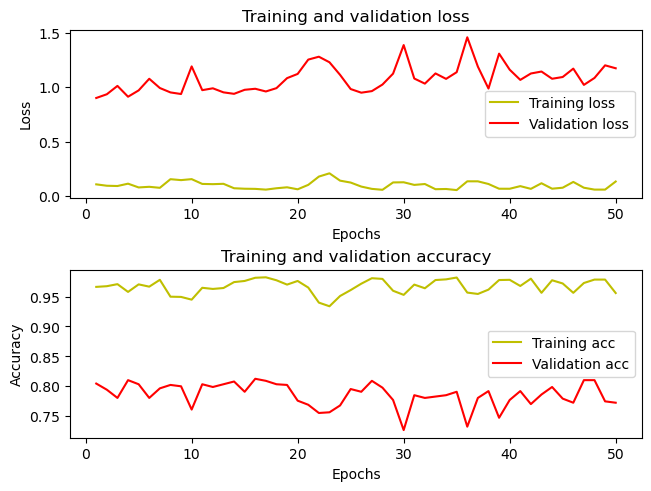

In [68]:
train_model(model,batch_size=16,epochs=50)

## Using pretrained models 

In [31]:
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import datetime

In [72]:
# !pip install tensorflow_hub

In [260]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [261]:
# %reload_ext tensorboard

In [60]:
SIZE=224
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/all_images/', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image_224'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [61]:
skin_df_balanced['image_224'] = skin_df_balanced['path'].map(lambda x:tf.keras.utils.img_to_array(tf.keras.utils.load_img(x,target_size=(SIZE,SIZE))))
                                                                                                                        

In [62]:
skin_df_balanced['image_224'][0].shape

(224, 224, 3)

In [63]:
X = np.asarray(skin_df_balanced['image_224'].tolist())
# X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [65]:
x_train.shape

(2625, 224, 224, 3)

In [66]:
y_train.shape

(2625, 7)

### Mobilenet v2 (without fine-tuning)

In [248]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

num_classes = 7
model_mobilenet_v2 = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model_mobilenet_v2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [266]:
model_mobilenet_v2.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model_name = "mobilenet_v2_"
log_dir = "logs/fit/" + model_name + datetime.datetime.now().strftime("%d-%m-%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
# print(log_dir)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=5,min_delta=0.005)

checkpoint_filepath = 'models/mobilenet_v2_best.h5'
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_acc',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')


In [267]:
NUM_EPOCHS = 20

history = model_mobilenet_v2.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback,es,mc])

Epoch 1/20


2022-12-02 15:57:30.400967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.7458 - acc: 0.7581

2022-12-02 15:58:00.966198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 43s 491ms/step - loss: 0.7458 - acc: 0.7581 - val_loss: 1.2407 - val_acc: 0.5520
Epoch 2/20
83/83 [==============================] - 39s 475ms/step - loss: 0.7045 - acc: 0.7848 - val_loss: 1.2499 - val_acc: 0.5406
Epoch 3/20
83/83 [==============================] - 39s 477ms/step - loss: 0.6888 - acc: 0.7829 - val_loss: 1.2691 - val_acc: 0.5269
Epoch 4/20
83/83 [==============================] - 39s 472ms/step - loss: 0.6679 - acc: 0.7947 - val_loss: 1.2544 - val_acc: 0.5440
Epoch 5/20
83/83 [==============================] - 39s 475ms/step - loss: 0.6341 - acc: 0.8133 - val_loss: 1.2527 - val_acc: 0.5566
Epoch 6/20
83/83 [==============================] - 39s 474ms/step - loss: 0.6162 - acc: 0.8164 - val_loss: 1.2784 - val_acc: 0.5303
Epoch 6: early stopping


In [276]:
score = model_mobilenet_v2.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 10s 344ms/step - loss: 1.2784 - acc: 0.5303
Test accuracy: 0.5302857160568237


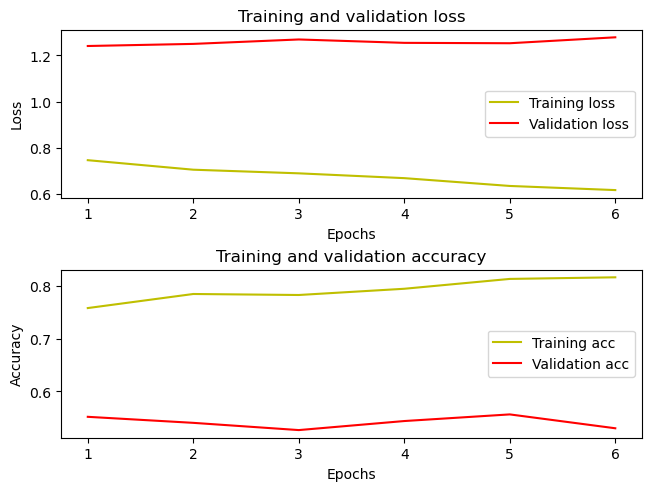

In [269]:
#plot the training and validation accuracy and loss at each epoch
fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.show()

In [270]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6631), started 0:16:03 ago. (Use '!kill 6631' to kill it.)

### Efficientnet v2

In [271]:
efficientnet_v2 ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
num_classes = 7
model_effnetv2 = tf.keras.Sequential([
    hub.KerasLayer(efficientnet_v2,
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_effnetv2.build([None, 224, 224, 3])  # Batch input shape.

In [272]:
model_effnetv2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dense_7 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 5,928,279
Trainable params: 8,967
Non-trainable params: 5,919,312
_________________________________________________________________


In [274]:
model_effnetv2.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model_name = "efficientnet_v2_"
log_dir = "logs/fit/" + model_name + datetime.datetime.now().strftime("%d-%m-%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print(log_dir)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=5,min_delta=0.005)

checkpoint_filepath = 'models/effnet_v2_best.h5'
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_acc',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')

logs/fit/efficientnet_v2_02-12-2022-161323


In [275]:

NUM_EPOCHS = 20

history = model_effnetv2.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback,es,mc])

Epoch 1/20


2022-12-02 16:13:34.896736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.7093 - acc: 0.3448

2022-12-02 16:13:50.477759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 24s 241ms/step - loss: 1.7093 - acc: 0.3448 - val_loss: 1.5576 - val_acc: 0.4274
Epoch 2/20
83/83 [==============================] - 14s 172ms/step - loss: 1.4886 - acc: 0.4533 - val_loss: 1.4626 - val_acc: 0.4526
Epoch 3/20
83/83 [==============================] - 14s 167ms/step - loss: 1.3982 - acc: 0.4891 - val_loss: 1.4180 - val_acc: 0.4503
Epoch 4/20
83/83 [==============================] - 14s 170ms/step - loss: 1.3428 - acc: 0.5090 - val_loss: 1.3917 - val_acc: 0.4663
Epoch 5/20
83/83 [==============================] - 14s 170ms/step - loss: 1.2986 - acc: 0.5284 - val_loss: 1.3556 - val_acc: 0.4834
Epoch 6/20
83/83 [==============================] - 14s 171ms/step - loss: 1.2639 - acc: 0.5413 - val_loss: 1.3515 - val_acc: 0.4857
Epoch 7/20
83/83 [==============================] - 14s 170ms/step - loss: 1.2310 - acc: 0.5566 - val_loss: 1.3022 - val_acc: 0.5040
Epoch 8/20
83/83 [==============================] - 14s 167ms/step - loss: 1.213

In [277]:
score = model_effnetv2.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 3s 115ms/step - loss: 1.2286 - acc: 0.5440
Test accuracy: 0.543999969959259


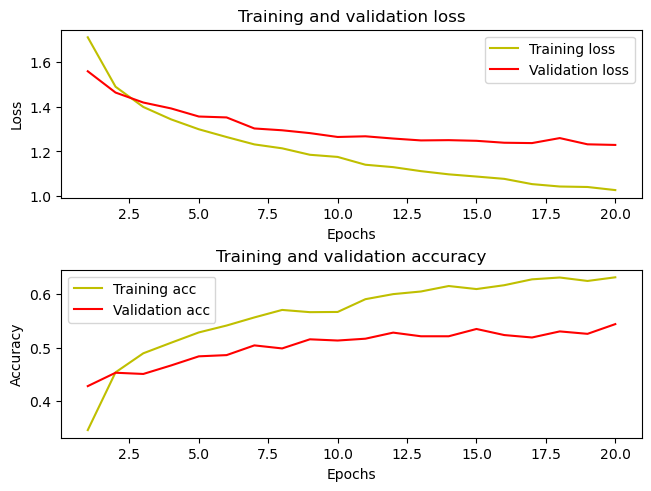

In [278]:
#plot the training and validation accuracy and loss at each epoch
fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.show()

In [279]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6631), started 0:47:18 ago. (Use '!kill 6631' to kill it.)

### Fine tuning effnetv2

In [280]:
efficientnet_v2 ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
num_classes = 7
model_effnetv2_ft = tf.keras.Sequential([
    hub.KerasLayer(efficientnet_v2,
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_effnetv2_ft.build([None, 224, 224, 3])  # Batch input shape.

In [281]:
model_effnetv2_ft.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dense_8 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 5,928,279
Trainable params: 5,867,671
Non-trainable params: 60,608
_________________________________________________________________


In [291]:
model_effnetv2_ft.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model_name = "efficientnet_v2_ft_" #ft - finetuned
log_dir = "logs/fit/" + model_name + datetime.datetime.now().strftime("%d-%m-%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print(log_dir)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=10,min_delta=0.005)

checkpoint_filepath = 'models/effnet_v2_ft_best.h5'
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_acc',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')

logs/fit/efficientnet_v2_ft_02-12-2022-172215


In [292]:
NUM_EPOCHS = 30

history = model_effnetv2_ft.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback,es,mc])

Epoch 1/30


2022-12-02 17:22:36.438683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.2266 - acc: 0.9265

2022-12-02 17:23:26.983354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 60s 606ms/step - loss: 0.2266 - acc: 0.9265 - val_loss: 1.3286 - val_acc: 0.6526
Epoch 2/30
83/83 [==============================] - 43s 513ms/step - loss: 0.1581 - acc: 0.9448 - val_loss: 1.2864 - val_acc: 0.7177
Epoch 3/30
83/83 [==============================] - 40s 478ms/step - loss: 0.1735 - acc: 0.9398 - val_loss: 1.2266 - val_acc: 0.6709
Epoch 4/30
83/83 [==============================] - 40s 482ms/step - loss: 0.1447 - acc: 0.9539 - val_loss: 1.2897 - val_acc: 0.6926
Epoch 5/30
83/83 [==============================] - 40s 483ms/step - loss: 0.1170 - acc: 0.9604 - val_loss: 1.4024 - val_acc: 0.6800
Epoch 6/30
83/83 [==============================] - 39s 474ms/step - loss: 0.1507 - acc: 0.9516 - val_loss: 1.1586 - val_acc: 0.6937
Epoch 7/30
83/83 [==============================] - 40s 478ms/step - loss: 0.1148 - acc: 0.9611 - val_loss: 1.3178 - val_acc: 0.6846
Epoch 8/30
83/83 [==============================] - 39s 471ms/step - loss: 0.163

In [293]:
score = model_effnetv2_ft.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 3s 117ms/step - loss: 2.0647 - acc: 0.4846
Test accuracy: 0.4845714271068573


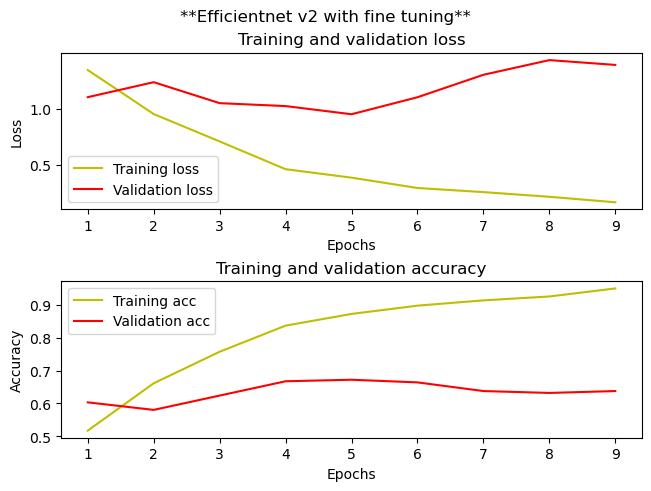

In [290]:
#plot the training and validation accuracy and loss at each epoch
fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Efficientnet v2 with fine tuning - 10 epochs**')

fig.show()

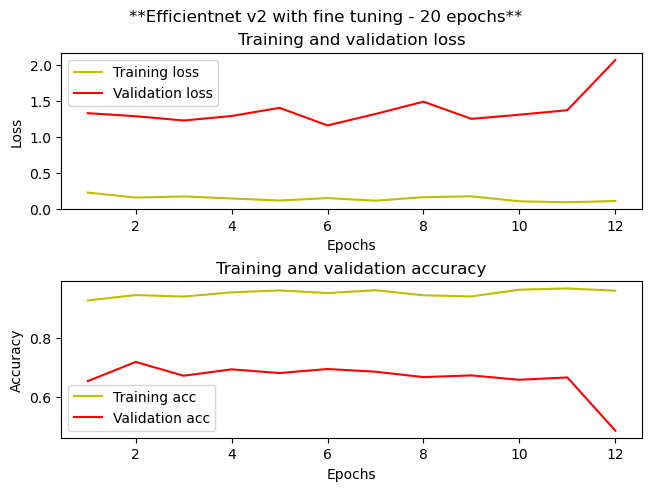

In [294]:
fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Efficientnet v2 with fine tuning - 20 epochs**')

fig.show()

In [298]:
y_pred = model_effnetv2_ft.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

2022-12-02 20:55:06.159500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 7s 168ms/step


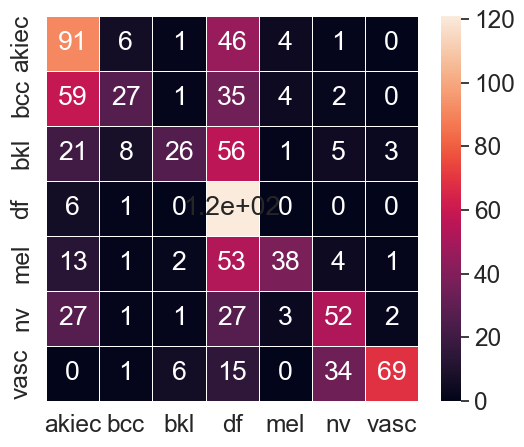

In [308]:

#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
ax.xaxis.set_ticklabels(list(le.classes_))
ax.yaxis.set_ticklabels(list(le.classes_))
fig.show()

In [307]:
# print(list(le.classes_))

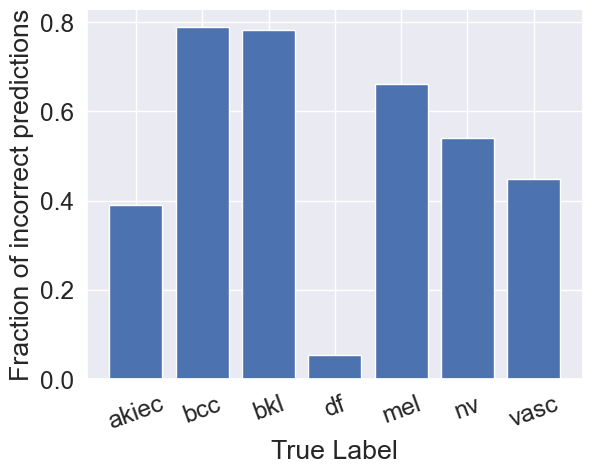

In [309]:

#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks([0,1,2,3,4,5,6], list(le.classes_),rotation=20)
plt.show()


In [315]:
from tabulate import tabulate
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(tabulate({"Type":list(le.classes_),
               "Recall":recall,
               "Precision":precision},headers="keys"))

Type      Recall    Precision
------  --------  -----------
akiec   0.610738     0.419355
bcc     0.210938     0.6
bkl     0.216667     0.702703
df      0.945312     0.342776
mel     0.339286     0.76
nv      0.460177     0.530612
vasc    0.552        0.92


## Fine tuning MobileNetV2

In [32]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top =False,
                                              weights='imagenet')
base_model.trainable =True

Metal device set to: Apple M2


2022-12-02 22:09:44.431948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 22:09:44.432230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [318]:
len(base_model.layers)

154

In [320]:
base_model.layers[-1].output_shape

(None, 7, 7, 1280)

In [34]:
rescale = tf.keras.layers.Rescaling(1.0/112.0,offset=-1)

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [50]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 8967

In [53]:
# first: training only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [54]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 8967

In [70]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model_name = "mobilenetv2_ft" #ft - finetuned
log_dir = "logs/fit/" + model_name + datetime.datetime.now().strftime("%d-%m-%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print(log_dir)

# es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=10,min_delta=0.005)

checkpoint_filepath = 'models/mobilenetv2_ft_best.h5'
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_acc',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')

logs/fit/mobilenetv2_ft02-12-2022-223339


In [81]:
len(model.trainable_variables)

0

In [72]:
NUM_EPOCHS = 20

history = model.fit(x_train,y_train,
                    validation_data=(x_test,y_test),
                    epochs=NUM_EPOCHS
                    callbacks=[tensorboard_callback,mc])

Epoch 1/20


2022-12-02 22:33:49.417497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.8111 - acc: 0.3371

2022-12-02 22:34:03.501946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 18s 198ms/step - loss: 1.8111 - acc: 0.3371 - val_loss: 1.5174 - val_acc: 0.4343
Epoch 2/20
83/83 [==============================] - 12s 150ms/step - loss: 1.4475 - acc: 0.4632 - val_loss: 1.4174 - val_acc: 0.4651
Epoch 3/20
83/83 [==============================] - 12s 148ms/step - loss: 1.2924 - acc: 0.5303 - val_loss: 1.3790 - val_acc: 0.4697
Epoch 4/20
83/83 [==============================] - 12s 149ms/step - loss: 1.2125 - acc: 0.5585 - val_loss: 1.3396 - val_acc: 0.4983
Epoch 5/20
83/83 [==============================] - 12s 149ms/step - loss: 1.1568 - acc: 0.5882 - val_loss: 1.2948 - val_acc: 0.5166
Epoch 6/20
83/83 [==============================] - 12s 148ms/step - loss: 1.0848 - acc: 0.6122 - val_loss: 1.3056 - val_acc: 0.4983
Epoch 7/20
83/83 [==============================] - 12s 148ms/step - loss: 1.0309 - acc: 0.6278 - val_loss: 1.2698 - val_acc: 0.5314
Epoch 8/20
83/83 [==============================] - 12s 151ms/step - loss: 1.003

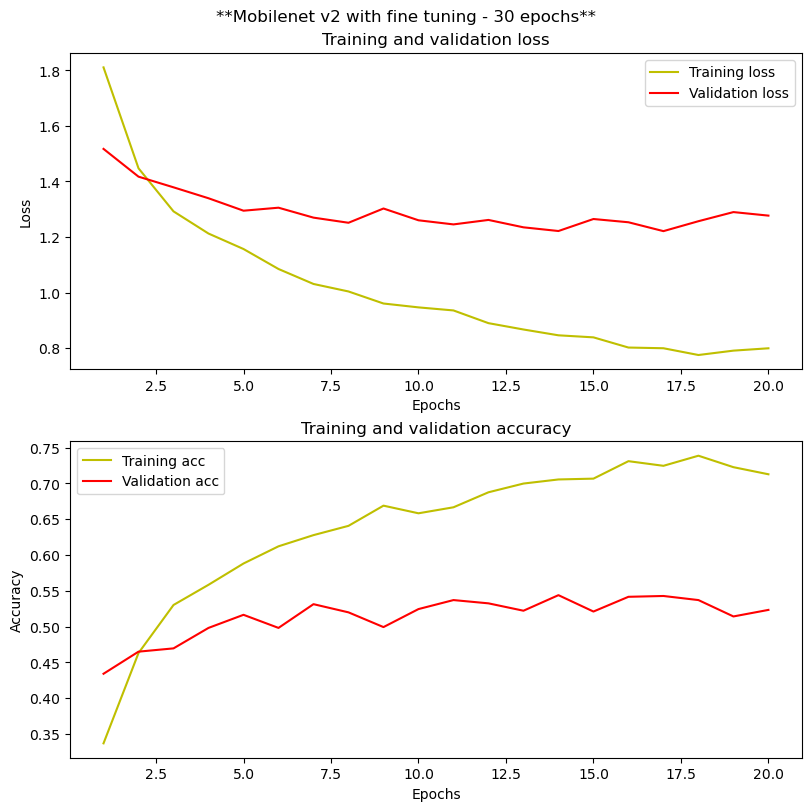

In [73]:
#plot the training and validation accuracy and loss at each epoch
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Mobilenet v2 with fine tuning - 30 epochs**')

fig.show()

In [74]:
## un freezing convolution layers

for i, layer in enumerate(base_model.layers):
       print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [117]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top =False,
                                              weights='imagenet')
base_model.trainable =True

inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [113]:
# for layer in model.layers[:147]:
# #        layer.trainable = False
# for layer in base_model.layers[0:150]:
#        layer.trainable = True

In [120]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

In [121]:
len(model.trainable_variables)

158

In [122]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 7)                 8967

In [123]:
## continue training for 20 more epochs

extend_epochs =20
total_epochs = NUM_EPOCHS +extend_epochs

history_finetune = model.fit(x_train,y_train,
                            validation_data =(x_test,y_test),
                            initial_epoch=history.epoch[-1],
                            epochs = total_epochs,
                            callbacks=[tensorboard_callback,mc])

Epoch 20/40


2022-12-02 22:49:56.531756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.8442 - acc: 0.2693

2022-12-02 22:50:30.892570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 41s 411ms/step - loss: 1.8442 - acc: 0.2693 - val_loss: 1.6809 - val_acc: 0.3646
Epoch 21/40
83/83 [==============================] - 32s 383ms/step - loss: 1.7060 - acc: 0.3147 - val_loss: 1.5834 - val_acc: 0.3783
Epoch 22/40
83/83 [==============================] - 31s 379ms/step - loss: 1.5582 - acc: 0.3882 - val_loss: 1.5333 - val_acc: 0.4091
Epoch 23/40
83/83 [==============================] - 31s 378ms/step - loss: 1.5086 - acc: 0.4160 - val_loss: 1.3911 - val_acc: 0.4686
Epoch 24/40
83/83 [==============================] - 31s 378ms/step - loss: 1.4376 - acc: 0.4434 - val_loss: 1.5147 - val_acc: 0.3714
Epoch 25/40
83/83 [==============================] - 32s 380ms/step - loss: 1.4187 - acc: 0.4568 - val_loss: 1.3025 - val_acc: 0.5406
Epoch 26/40
83/83 [==============================] - 31s 378ms/step - loss: 1.3770 - acc: 0.4781 - val_loss: 1.4806 - val_acc: 0.4503
Epoch 27/40
83/83 [==============================] - 31s 376ms/step - loss

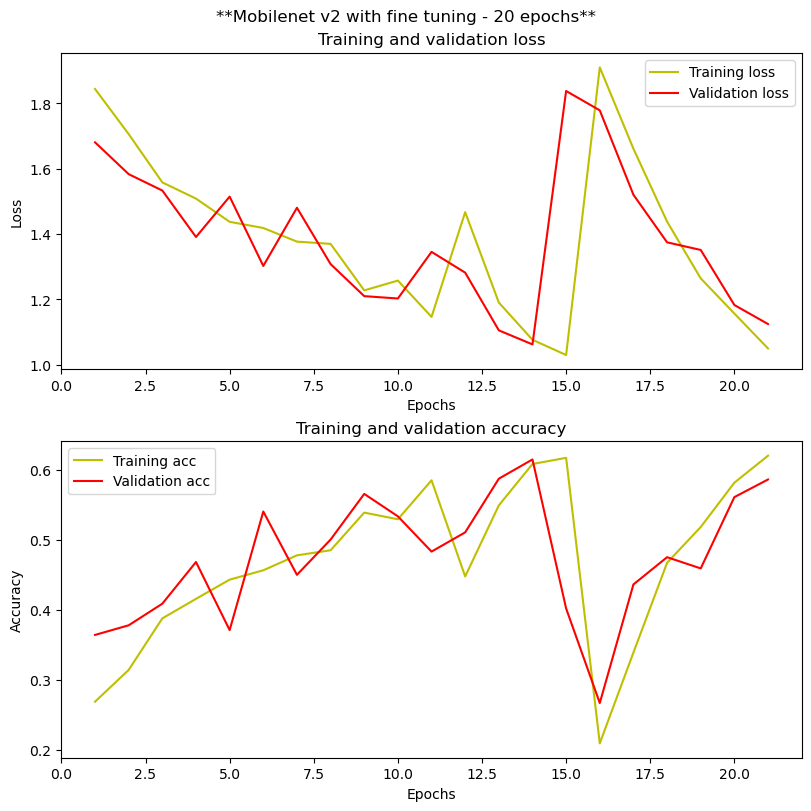

In [125]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),constrained_layout=True)
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history_finetune.history['acc']
val_acc = history_finetune.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Mobilenet v2 with fine tuning - 20 epochs**')

fig.show()

In [127]:
## continue training for 25 more epochs

extend_epochs =25
total_epochs = 65

history_finetune_2 = model.fit(x_train,y_train,
                            validation_data =(x_test,y_test),
                            initial_epoch=history_finetune.epoch[-1],
                            epochs = total_epochs,
                            callbacks=[tensorboard_callback,mc])

Epoch 40/65
83/83 [==============================] - 39s 451ms/step - loss: 0.7894 - acc: 0.7227 - val_loss: 0.9875 - val_acc: 0.6469
Epoch 41/65
83/83 [==============================] - 31s 373ms/step - loss: 0.7973 - acc: 0.7093 - val_loss: 1.0442 - val_acc: 0.6423
Epoch 42/65
83/83 [==============================] - 31s 373ms/step - loss: 0.7385 - acc: 0.7330 - val_loss: 1.0221 - val_acc: 0.6217
Epoch 43/65
83/83 [==============================] - 31s 371ms/step - loss: 0.7380 - acc: 0.7375 - val_loss: 1.1101 - val_acc: 0.6183
Epoch 44/65
83/83 [==============================] - 31s 371ms/step - loss: 0.7565 - acc: 0.7318 - val_loss: 1.1847 - val_acc: 0.5783
Epoch 45/65
83/83 [==============================] - 31s 370ms/step - loss: 0.7270 - acc: 0.7493 - val_loss: 1.1453 - val_acc: 0.5909
Epoch 46/65
83/83 [==============================] - 884s 11s/step - loss: 0.7028 - acc: 0.7501 - val_loss: 0.9506 - val_acc: 0.6571
Epoch 47/65
83/83 [==============================] - 880s 11s/s

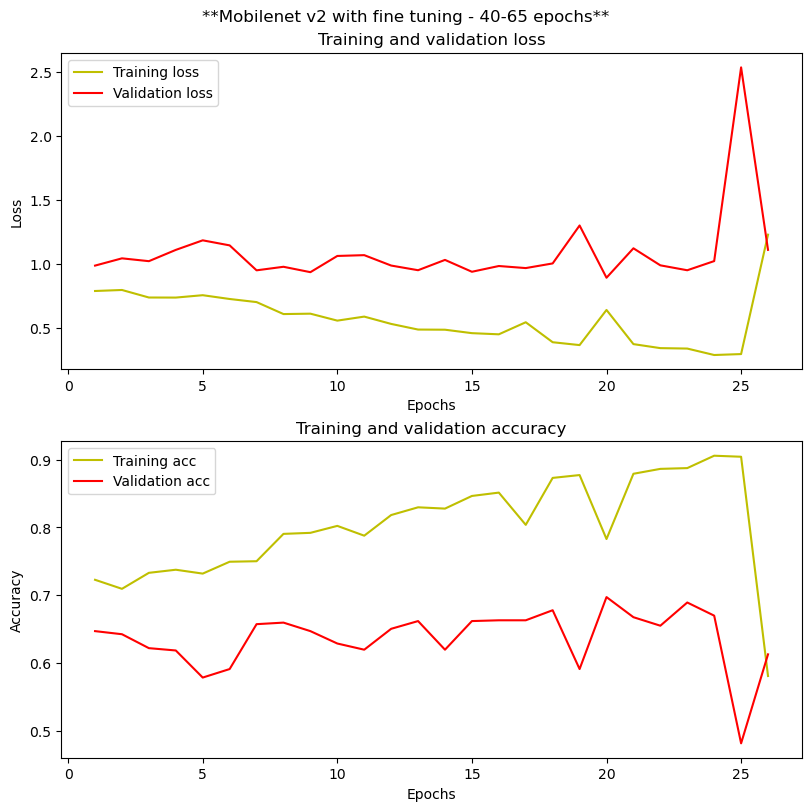

In [128]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),constrained_layout=True)
loss = history_finetune_2.history['loss']
val_loss = history_finetune_2.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history_finetune_2.history['acc']
val_acc = history_finetune_2.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Mobilenet v2 with fine tuning - 40-65 epochs**')

fig.show()

In [132]:
for layer in base_model.layers[:140]:
       layer.trainable = False
for layer in base_model.layers[140:154]:
       layer.trainable = True

In [147]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

In [148]:
len(model.trainable_variables)

17

In [138]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 7)                 8967

In [139]:
extend_epochs =25
total_epochs = 90

history_finetune_3 = model.fit(x_train,y_train,
                            validation_data =(x_test,y_test),
                            initial_epoch=history_finetune_2.epoch[-1],
                            epochs = total_epochs,
                            callbacks=[tensorboard_callback,mc])

Epoch 65/90


2022-12-04 18:14:04.242567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.7068 - acc: 0.7310

2022-12-04 18:14:18.154291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 19s 206ms/step - loss: 0.7068 - acc: 0.7310 - val_loss: 1.0134 - val_acc: 0.6491
Epoch 66/90
83/83 [==============================] - 14s 167ms/step - loss: 0.6541 - acc: 0.7577 - val_loss: 1.0313 - val_acc: 0.6480
Epoch 67/90
83/83 [==============================] - 14s 165ms/step - loss: 0.6017 - acc: 0.7802 - val_loss: 0.9812 - val_acc: 0.6514
Epoch 68/90
83/83 [==============================] - 14s 165ms/step - loss: 0.5720 - acc: 0.7817 - val_loss: 0.9792 - val_acc: 0.6754
Epoch 69/90
83/83 [==============================] - 14s 165ms/step - loss: 0.5444 - acc: 0.7985 - val_loss: 0.9975 - val_acc: 0.6446
Epoch 70/90
83/83 [==============================] - 14s 165ms/step - loss: 0.5666 - acc: 0.7882 - val_loss: 0.9755 - val_acc: 0.6583
Epoch 71/90
83/83 [==============================] - 14s 165ms/step - loss: 0.5173 - acc: 0.8103 - val_loss: 1.1035 - val_acc: 0.6229
Epoch 72/90
83/83 [==============================] - 14s 167ms/step - loss

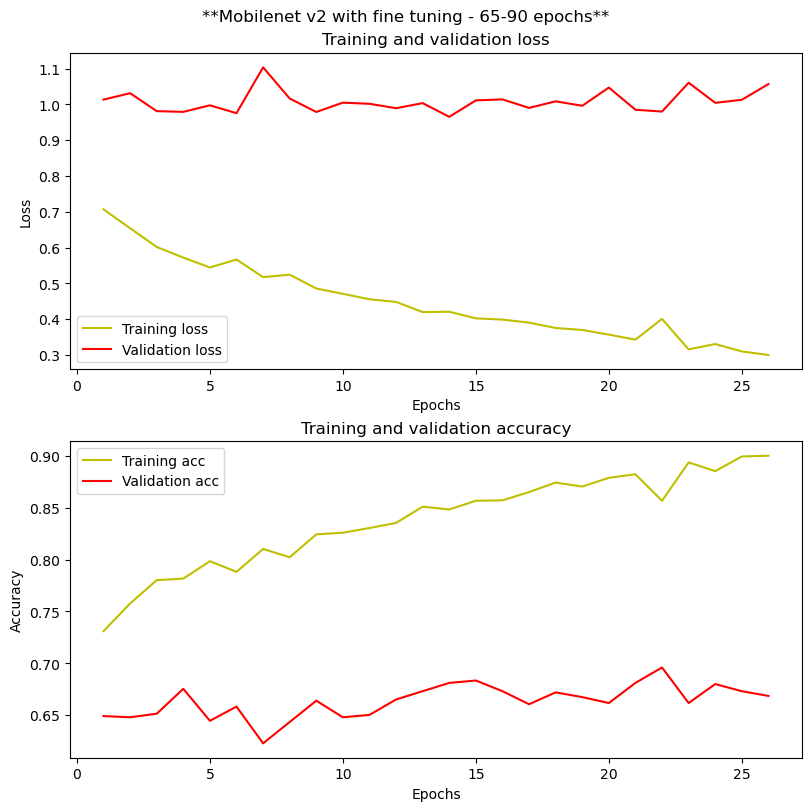

In [140]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),constrained_layout=True)
loss = history_finetune_3.history['loss']
val_loss = history_finetune_3.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history_finetune_3.history['acc']
val_acc = history_finetune_3.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Mobilenet v2 with fine tuning - 65-90 epochs**')

fig.show()

In [149]:
extend_epochs =25
total_epochs = 120

history_finetune_4 = model.fit(x_train,y_train,
                            validation_data =(x_test,y_test),
                            initial_epoch=history_finetune_3.epoch[-1],
                            epochs = total_epochs,
                            callbacks=[tensorboard_callback,mc])

Epoch 90/120


2022-12-04 18:34:00.500332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.4786 - acc: 0.8229

2022-12-04 18:34:12.030620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 17s 183ms/step - loss: 0.4786 - acc: 0.8229 - val_loss: 1.3100 - val_acc: 0.6320
Epoch 91/120
83/83 [==============================] - 14s 166ms/step - loss: 0.4342 - acc: 0.8347 - val_loss: 1.3239 - val_acc: 0.6434
Epoch 92/120
83/83 [==============================] - 14s 165ms/step - loss: 0.4283 - acc: 0.8347 - val_loss: 1.3014 - val_acc: 0.6514
Epoch 93/120
83/83 [==============================] - 14s 165ms/step - loss: 0.4213 - acc: 0.8404 - val_loss: 1.2982 - val_acc: 0.6514
Epoch 94/120
83/83 [==============================] - 14s 166ms/step - loss: 0.4385 - acc: 0.8377 - val_loss: 1.3194 - val_acc: 0.6457
Epoch 95/120
83/83 [==============================] - 14s 168ms/step - loss: 0.4079 - acc: 0.8438 - val_loss: 1.3258 - val_acc: 0.6343
Epoch 96/120
83/83 [==============================] - 14s 168ms/step - loss: 0.4040 - acc: 0.8484 - val_loss: 1.3315 - val_acc: 0.6606
Epoch 97/120
83/83 [==============================] - 14s 166ms/step

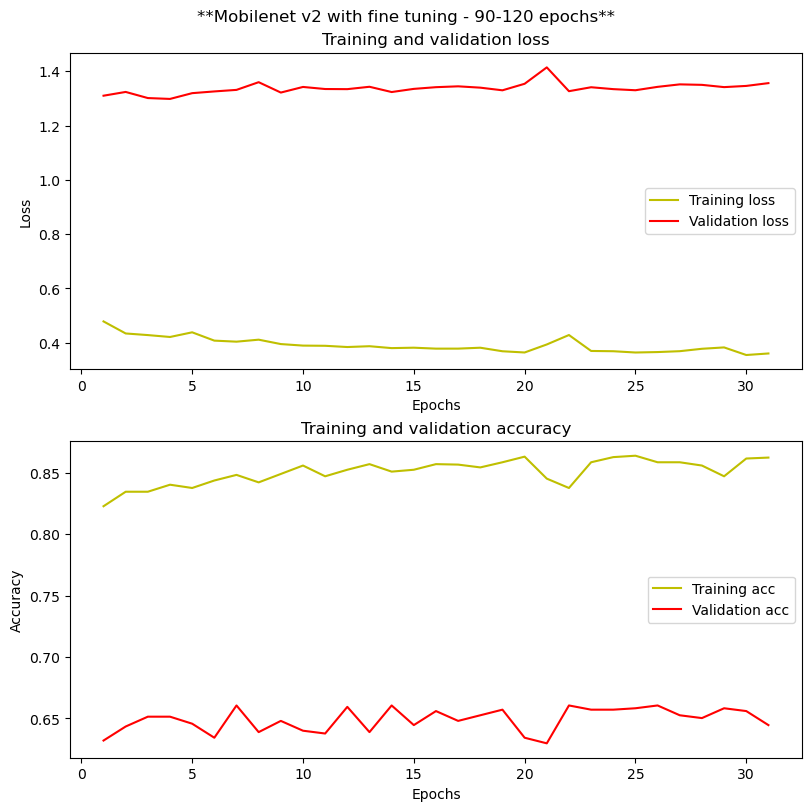

In [150]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),constrained_layout=True)
loss = history_finetune_4.history['loss']
val_loss = history_finetune_4.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

acc = history_finetune_4.history['acc']
val_acc = history_finetune_4.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('**Mobilenet v2 with fine tuning - 90-120 epochs**')

fig.show()

In [151]:
from sklearn.manifold import TSNE

In [154]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

In [157]:
for layer in base_model.layers[:]:
       layer.trainable = False
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [170]:
features = model2.predict(x_test)

2022-12-04 22:06:41.018194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 4s 110ms/step


In [171]:
features.shape

(875, 1280)

In [172]:
tsne = TSNE(n_components=2).fit_transform(features)

In [173]:
tsne.shape

(875, 2)

In [166]:
labels = np.argmax(model.predict(x_test), axis=1)

2022-12-04 22:05:33.694020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 4s 113ms/step


In [169]:
from collections import Counter
Counter(labels)

Counter({3: 136, 4: 126, 0: 80, 1: 182, 6: 132, 2: 111, 5: 108})

In [177]:
y_true = np.argmax(y_test,axis=1)
Counter(y_true)

Counter({3: 128, 4: 112, 0: 149, 2: 120, 5: 113, 6: 125, 1: 128})

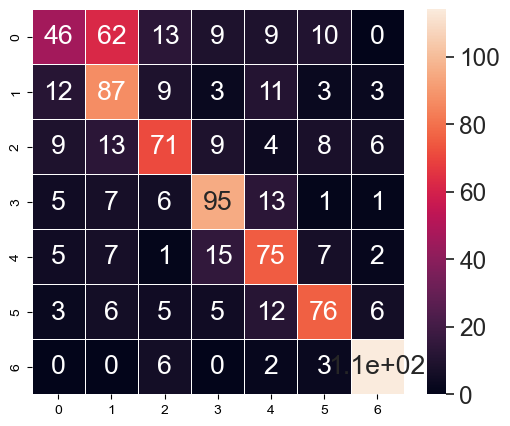

In [178]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, labels)
fig, ax = plt.subplots(figsize=(6,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
fig.show()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


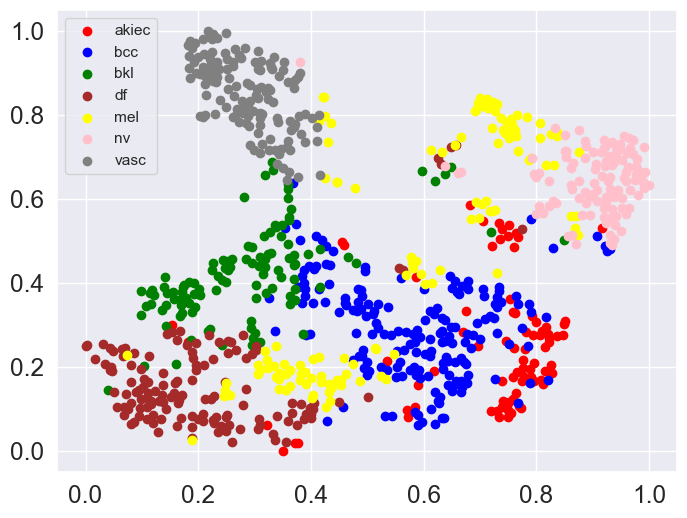

In [192]:
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

colors = ['red', 'blue', 'green', 'brown', 'yellow','pink','grey']
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classes)

fig, ax= plt.subplots(figsize=(8,6))

for idx, c in enumerate(colors):
    index = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, index)
    current_ty = np.take(ty, index)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

ax.legend(loc='best',fontsize = 'xx-small')

In [193]:
from sklearn.metrics import classification_report

In [197]:
print(classification_report(y_true,labels,target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))

              precision    recall  f1-score   support

       akiec       0.57      0.31      0.40       149
         bcc       0.48      0.68      0.56       128
         bkl       0.64      0.59      0.61       120
          df       0.70      0.74      0.72       128
         mel       0.60      0.67      0.63       112
          nv       0.70      0.67      0.69       113
        vasc       0.86      0.91      0.89       125

    accuracy                           0.64       875
   macro avg       0.65      0.65      0.64       875
weighted avg       0.65      0.64      0.64       875

